## Описание идеи
    Видимая змейкой область ограничена небольшим полем (змеи плохо видят). Размер поля задается параметром rang. По умолчанию его значение равно 2 - число клеток, видимых прямо, слева, сзади и справа змейки. Голова змейки темнее её хвоста.
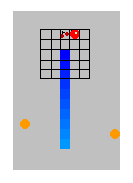    

    Препятствия (тело змейки, край поля, капролит) помечаются на поле - 1, фрукт - 2, а пустые клетки - 0.
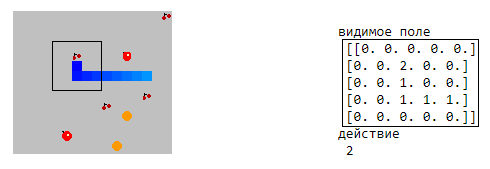
       
    Пример данного поля будет сохранен в наблюдениях в следующем виде:
    [[0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]]     [2]
    наблюдение (объект)                                                                целевая переменная (ответ)
    
    Направление движения (действия) кодируется так: 1 - двигаться влево; 2 - двигаться вправо; 3 - двигаться налево. Данные коды это классы для алгоритма KNN. Направление движения в режиме разметки задается пользователем, см. дальше.   
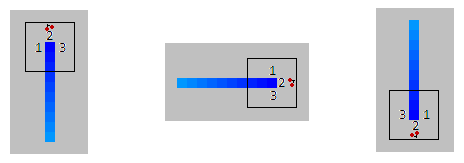
    
    Порядок действий:
    1. В режиме разметки перемещаем змейку стрелками, огибая препятствия, съедая фрукты. 
    2. Считываем разметку. Смотрим на дисбаланс классов. Используя встроенный в алгоритм KNN скользящий контроль оцениваем качество работы алгоритма.
    3. Запускаем змейку в режиме управления (AI = True).
    4. После быстрой смерти змейки... 8( пробуем различные методы перебалансировки наблюдений по классам или генерации новых наблюдений. Далее повторяем п.3. 

## Импорт библиотек

In [1]:
import numpy as np
import pygame as pg
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tq
import seaborn as sns

pygame 2.0.1 (SDL 2.0.14, Python 3.7.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Задание поля, цвета фруктов и параметров змейки

In [2]:
CS = 10  # ширина змейки
WIDTH = 50  # ширина поля, ось х
HIGH = 50  # высота поля, ось у

bg_color = (192, 192, 192)  # цвет фона
sn_color = (0, 0, 255)  # цвет змейки

# цвет фруктов
apple = (255, 0, 0)
apple2 = (255, 255, 196)

cherry = (192, 0, 0)
orange = (255, 153, 0)

## Класс змейки

In [3]:
class Snake:
    def __init__(self, lenght=10, rang=3, grow=True):
        self.grow = grow  # расти змейке или нет
        self.lenght = lenght  # длина нерастущей змейки
        self.alive = True
        self.timer = 0
        self.score = [0]
        self.x = []
        self.y = []
        self.I_see = []  # то, что змейка видит
        self.rang = rang  # размер видимой змейкой области
        self.all_ones = np.ones((HIGH + self.rang * 2, WIDTH + self.rang * 2))
        self.objects = None
        self.movements = []

        self.direction = 0

        key = True

        # расположение змейки на поле
        while key:
            x = random.randrange(0, WIDTH)
            y = random.randrange(0, HIGH)

            if field[y][x] == 0:
                self.x.insert(0, x)
                self.y.insert(0, y)
                field[self.y[0]][self.x[0]] = 1
                key = False

        self.plot(delete_tail=False)

    def move(self, dx, dy):
        # обработка движения змейки
        if self.x[0] + dx < 0 or self.x[
                0] + dx == WIDTH:  # ударилась о край поля - умерла
            self.died()
            return (False)

        if self.y[0] + dy < 0 or self.y[
                0] + dy == HIGH:  # ударилась о край поля - умерла
            self.died()
            return (False)

        if field[self.y[0] + dy][self.x[0] +
                                 dx] == 1:  # ударилась в себя - умерла
            self.died()
            return (False)

        if dx > 0: self.direction = 1  # двигаться вправо по полю
        if dx < 0: self.direction = 3  # двигаться влево
        if dy > 0: self.direction = 2  # двигаться вниз
        if dy < 0: self.direction = 0  # двигаться вверх

        self.x.insert(0, self.x[0] + dx)
        self.y.insert(0, self.y[0] + dy)

        delete_tail = True  # удалять хвост или нет
        if len(self.x) < self.lenght:
            delete_tail = False

        self.timer += 1

        if field[self.y[0]][self.x[0]] == 2:  # съела фрукт
            s_catch.play()
            snake.score[-1] += 1
            self.timer = 0
            if self.grow:
                delete_tail = False

        field[self.y[0]][
            self.x[0]] = 1  # заполнить клетку массива поля головой змеки (1)
        self.plot(delete_tail)

        return (True)

    def what_you_see(self):
        # вернуть то, что видит змейка
        return (self.I_see)

    def died(self):
        # если змейка умерла, разрисовать ее в серый цвет
        for x, y in zip(self.x, self.y):
            pg.draw.rect(window, bg_color, (x * CS, y * CS, CS, CS))
            pg.draw.rect(window, (100, 100, 100),
                         (x * CS + 1, y * CS + 1, CS - 1, CS - 1))
            self.plot_seing_area(0, bg_color)
            self.alive = False
        pg.display.update()
        return

    def get_seing_direction(self):
        # как змейка повернута относительно поля
        if len(self.x) < 2:
            return ("UP")
        if self.x[0] > self.x[1]:
            return ("RIGHT")
        if self.x[0] < self.x[1]:
            return ("LEFT")
        elif self.y[0] < self.y[1]:
            return ("UP")

        return ("DOWN")

    def plot_seing_area(self, index, color):
        # рисовать квадрат видимой змейкой части поля
        try:
            pg.draw.rect(
                window,
                color,
                (int(self.x[index] * CS - CS * self.rang),
                 int(self.y[index] * CS - CS * self.rang),
                 int(CS * 2 * self.rang + CS), int(CS * 2 * self.rang + CS)),
                width=1)
        except:
            pass

        return

    def plot(self, delete_tail):
        # удалить квадрат видимой змейкой части поля
        try:
            self.plot_seing_area(1, bg_color)
        except:
            pass

        if delete_tail:
            pg.draw.rect(window, bg_color,
                         (self.x[-1] * CS, self.y[-1] * CS, CS, CS))
            field[self.y[-1]][self.x[-1]] = 0

            self.x.pop()
            self.y.pop()
        else:
            # если хвост растёт, с низкой вероятностью отбрасывать капролит
            if random.choice([1] + [0] * 9) and len(self.x) >= self.lenght:
                field[self.y[-1]][self.x[-1]] = 1
                pg.draw.rect(window, bg_color,
                             (self.x[-1] * CS, self.y[-1] * CS, CS, CS))
                pg.draw.circle(
                    window, (0, 0, 0),
                    (self.x[-1] * CS + CS / 2, self.y[-1] * CS + CS / 2),
                    CS / 2.5)

                self.x.pop()
                self.y.pop()

        indx = 0
        # градиент цвета змейки
        stp = 168 / len(self.x)

        # рисовать змейку
        for x, y in zip(self.x, self.y):
            pg.draw.rect(window, (0, int(stp * indx), 255),
                         (x * CS, y * CS, CS, CS))
            pg.display.update()
            indx += 1

        # рисовать квадрат видимой змейкой части поля
        self.plot_seing_area(0, (0, 0, 0))

        pg.display.update()

        # заполнение массива поля
        self.all_ones[self.rang:HIGH + self.rang, self.rang:WIDTH +
                      self.rang] = field
        # что змейка видит
        sees = self.all_ones[self.y[0]:self.y[0] + self.rang * 2 +
                             1, self.x[0]:self.x[0] + self.rang * 2 + 1]
        # развернуть видимую часть поля
        sees = np.rot90(sees, k=self.direction)

        # видимую часть в строчку
        sees = np.reshape(sees, (1, -1))
        self.I_see = sees

        if len(self.x) < self.lenght - 1:
            return

        # добавляем наблюдение
        try:
            self.objects = np.concatenate(
                (self.objects, np.reshape(sees, (1, -1))))
        except:
            self.objects = np.reshape(sees, (1, -1))

        # добавляем действие к наблюдению
        # 2 - двигался прямо; 1 - двигался влево; 3 - двигался вправо
        if self.x[0] == self.x[1] == self.x[2]:
            self.movements.append(2)
        elif self.y[0] == self.y[1] == self.y[2]:
            self.movements.append(2)

        elif self.x[0] > self.x[1] and self.y[2] < self.y[1]:
            self.movements.append(1)
        elif self.y[0] > self.y[1] and self.x[1] < self.x[2]:
            self.movements.append(1)
        elif self.y[1] < self.y[2] and self.x[1] > self.x[0]:
            self.movements.append(1)
        elif self.x[2] < self.x[1] and self.y[1] > self.y[0]:
            self.movements.append(1)

        elif self.x[0] < self.x[1] and self.y[2] < self.y[1]:
            self.movements.append(3)
        elif self.y[0] < self.y[1] and self.x[1] < self.x[2]:
            self.movements.append(3)
        elif self.y[1] < self.y[2] and self.x[1] < self.x[0]:
            self.movements.append(3)
        elif self.x[2] < self.x[1] and self.y[1] < self.y[0]:
            self.movements.append(3)

        if not AI:
            print("действие\n", self.movements[-1])
            s = int(np.sqrt(snake.objects.shape[1]))
            print("\nвидимое поле\n", np.reshape(self.objects[-1], (s, s)))

    def get_data(self):
        # возвращаем запрошенные наблюдения-действия
        return (self.objects, self.movements)

## Класс фруктов

In [4]:
class Fruits:
    def __init__(self, k=20):
        self.k = k

    def add_fruit(self):
        while np.count_nonzero(field == 2.0) < self.k:
            x = random.randrange(0, WIDTH)
            y = random.randrange(0, HIGH)

            if field[y][x] == 0.0:
                field[y][x] = 2.0

                self.plot(int(x), int(y))

    def plot(self, x, y):
        r1 = int(CS / 2)
        r2 = int(CS / 6)
        r3 = int(CS / 5)

        choice = random.choice([0, 1, 2])

        if choice == 0:
            pg.draw.line(window, (0, 0, 0),
                         (int(x * CS + r1), int(y * CS + r1)),
                         (int(x * CS), int(y * CS)), 2)
            pg.draw.circle(window, apple,
                           (int(x * CS + CS / 2), int(y * CS + CS / 2)), r1)
            pg.draw.circle(window, apple2,
                           (int(x * CS + r1 + r2), int(y * CS + r1 - r2)), r2)
        elif choice == 1:
            center1 = (int(x * CS + CS * 0.25), int(y * CS + CS * 0.75))
            center2 = (int(x * CS + CS * 0.75), int(y * CS + CS * 0.5))
            center3 = (int(x * CS + CS * 0.25), int(y * CS + CS * 0.25))

            pg.draw.line(window, (0, 0, 0), center1, center3, 1)
            pg.draw.line(window, (0, 0, 0), center2, center3, 1)

            pg.draw.circle(window, cherry, center1, r3)
            pg.draw.circle(window, cherry, center2, r3)
        else:
            pg.draw.circle(window, orange,
                           (int(x * CS + CS / 2), int(y * CS + CS / 2)), r1)

        pg.display.update()

# Разметка. Работа AI

## Запуск змейки

In [10]:
# режим разметки (AI = False) или управления AI
AI = True

# расти змейке или нет
grow = False

# количество фруктов
fruits = 100

# самопереобучение при зацикливании
self_training = True

# размер видимой змейкой области
rang = 2

snakes = []
run = True

# массив поля, 0 - пусто, 1 - препятствие (змейка, край поля, капролит), 2 - фрукт
field = np.zeros((HIGH, WIDTH))

# окно поля
pg.mixer.pre_init(44100, -16, 1, 512)
pg.init()
s_catch = pg.mixer.Sound('caterpillar_bite.mp3')
window = pg.display.set_mode((WIDTH * CS, HIGH * CS))
pg.display.set_caption("Pensive Snake")
window.fill(bg_color)
pg.display.update()

some_fruits = Fruits(fruits)
some_fruits.add_fruit()

if AI:
    for i in range(5):  # количество змеек
        # rang - размер видимого змейкой поля
        # grow - расти змейке, съев фрукт, или нет
        snakes.append(Snake(rang=rang, grow=grow))
else:
    # ручная змейка для разметки
    snake = Snake(rang=rang, grow=grow)

while run:

    if not AI:
        # обработка событий клавиатуры
        for event in pg.event.get():
            if event.type == pg.QUIT:
                run = False

            dx, dy = 0, 0

            if event.type == pg.KEYDOWN:
                if event.key == pg.K_DOWN:
                    dy += 1
                elif event.key == pg.K_UP:
                    dy -= 1
                elif event.key == pg.K_LEFT:
                    dx -= 1
                elif event.key == pg.K_RIGHT:
                    dx += 1

            # если было собыите нажатия клавиш напрявления - двигаем змейку
            if dx or dy:
                snake.move(dx, dy)

    if AI:
        for event in pg.event.get():
            if event.type == pg.QUIT:
                run = False

        for snake in snakes:
            if snake.alive:
                # запрос классификатора о направлении движения
                # по видимому змейкой полю
                where_to_move = clf.predict(snake.what_you_see())
                # расчет направления движения в зависимости от положения змейки
                direction = snake.get_seing_direction()

                dx, dy = 0, 0

                if direction == "UP":
                    if where_to_move == 1: dx -= 1
                    if where_to_move == 2: dy -= 1
                    if where_to_move == 3: dx += 1

                elif direction == "DOWN":
                    if where_to_move == 1: dx += 1
                    if where_to_move == 2: dy += 1
                    if where_to_move == 3: dx -= 1

                elif direction == "LEFT":
                    if where_to_move == 1: dy += 1
                    if where_to_move == 2: dx -= 1
                    if where_to_move == 3: dy -= 1

                elif direction == "RIGHT":
                    if where_to_move == 1: dy -= 1
                    if where_to_move == 2: dx += 1
                    if where_to_move == 3: dy += 1

                snake.move(dx, dy)

                if snake.timer > 100 and self_training == True:
                    snake.timer = 0
                    clf.change_neihgbors_direction()
#                     print("Neihgbors direction was changed")

    some_fruits.add_fruit()

pg.quit()
print("SCORE: ", snake.score[0])

SCORE:  23


## Принудительное закрытие поля

pg.quit()

## Сохранение размеченных данных

In [ ]:
# если было ручное управление (разметка), записать разметку для классификатора
if not AI:
    X, y = snake.get_data()

    pd.DataFrame(X).to_pickle("objects.pcl")
    pd.DataFrame(y).to_pickle("targets.pcl")

# количество наблюдений и признаков
print("наблюдений:", X.shape[0], ", признаков:", X.shape[1])

## Чтение разметки. Просмотр баланса классов

наблюдений: 408 , признаков: 25


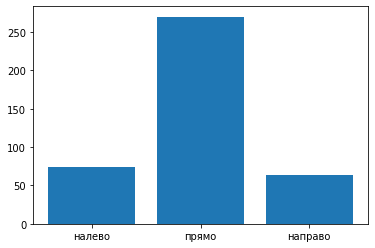

In [6]:
def plot_classes(y):
    data = {
        'налево': len(y[y == 1]),
        'прямо': len(y[y == 2]),
        'направо': len(y[y == 3])
    }

    fig, ax = plt.subplots()
    names = list(data.keys())
    values = list(data.values())

    ax.bar(names, values)
    plt.show()

method = "(начальный дисбаланс)"
    
# считываем разметку
X = np.array(pd.read_pickle("objects.pcl"))[:-1]
y = np.array(pd.read_pickle("targets.pcl")[0])[1:]

# удаляем повторяющиеся наблюдения
_, indexes = np.unique(X, axis=0, return_index=True)
X = X[indexes, :]
y = y[indexes]

# количество наблюдений и признаков
print("наблюдений:", X.shape[0], ", признаков:", X.shape[1])

X_res, y_res = X, y
plot_classes(y_res)

##  AI змейки (KNN). Инициализация.

In [7]:
class KNN:
    def __init__(self, k=3, method="std"):
        self.k = k
        self.method = method
        self.task = None
        self.last_indexes = []

    def change_neihgbors_direction(self):
        # метод для смены класса наблюдению в случае зацикливания змейки
        index = self.last_indexes[random.randint(0, self.k - 1)]
        choice = self.y_train[index]

        while choice == self.y_train[index]:
            choice = random.choice([1, 2, 3])

        self.y_train[index] = choice

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.find_task_type(y_train)
            
    def find_task_type(self, y_train):
        # метод распознавания типа решаемой задачи - классификация или регрессия
        self.task = "regression"
        if (y_train == y_train.astype(int)).sum() / len(y_train):
            self.task = "classification"

    def distance(self, x_test, x_train):
        return np.sqrt(np.sum((x_test - x_train)**2))

    def predict(self, X_test):
        labels = [self.find_labels(x_test) for x_test in X_test]
        return np.array(labels)

    def find_labels(self, x_test):
        distances = [self.distance(x_test, x_train) for x_train in self.X_train]
        k_nearest = np.argsort(distances)[:self.k]
        self.last_indexes = k_nearest
        k_labels = [self.y_train[i] for i in k_nearest]

        if self.task == "regression":
            return np.sum(k_labels) / self.k

        if self.method == "std":
            return self.most_common(k_labels)

        max_ = max(k_nearest)
        alpha = 0.1

        k_nearest = [1 / ((i + max_ * alpha) / max_) for i in k_nearest]

        a = [i for i in range(int(max(k_labels) + 1))]
        summ = [0] * int(max(k_labels) + 1)

        for index, value in enumerate(k_nearest):
            summ[int(k_labels[index])] += value

        return a[np.argsort(summ)[-1]]

    def most_common(self, k_labels):
        a = tuple(set(k_labels))
        most_common = [k_labels.count(i) for i in a]
        index = np.argsort(most_common)[-1]

        if len(set(most_common)) == 1 or len(most_common) == len(k_labels):
            return random.choice(a)

        return a[index]
    
    # методы проверки качества моделей для обоих типов задач
    def score(self, predicted, y_test):
        return (predicted == y_test).sum() / len(y_test)

    def r2(self, predicted, y_test):
        return 1 - np.sum((predicted - y_test)**2) / np.sum(
            (y_test.mean() - y_test)**2)
    
    # встроенный метод скользящего контроля (кросс валидация по фолдам)
    def cv(self, X, y, cv=5, disable=False):
        self.find_task_type(y)
        
        y = np.reshape(y, (len(y), 1))
        data = np.concatenate((X, y), axis=1)
        np.random.shuffle(data)

        data = pd.DataFrame(data)
        score = []

        for i in tq(range(cv), desc="Скользящий контроль: ", disable=disable):
            lenght = int(len(y) / cv)

            X_test = data.iloc[i * lenght:i * lenght + lenght, :-1]
            X_train = data.drop(index=X_test.index).iloc[:, :-1]

            y_test = data.iloc[i * lenght:i * lenght + lenght, -1]
            y_train = data.drop(index=X_test.index).iloc[:, -1]

            clf = KNN(method="new")
            clf.fit(np.array(X_train), np.array(y_train))
            predicted = clf.predict(np.array(X_test))

            if self.task == "classification":
                score.append(clf.score(predicted, np.array(y_test)))
            else:
                score.append(clf.r2(predicted, np.array(y_test)))

        return np.array(score)
    
    # метод оценки важности признаков (permutation importance)
    def feature_importance(self, X_res, y_res, cv=5):
        clf = KNN()
        original = clf.cv(X_res, y_res, cv=cv, disable=True).mean()

        importance = []

        for i in tq(range(X_res.shape[1]), desc="Оценка важности признаков"):
            X_new = X_res.copy()
            np.random.shuffle(X_new[:, i])

            cv = clf.cv(X_new, y_res, cv=5, disable=True)
            importance.append(np.mean(cv))

        s = int(np.sqrt(len(importance)))
        importance = np.array(importance - original).reshape(s, s)

        fig, axs = plt.subplots(figsize=(3, 3))
        sns.heatmap(importance, annot=True, vmin=0, fmt='0.2f', ax=axs, cbar=False)
        plt.show()

## Подбор параметра k алгоритма KNN


SMOTE


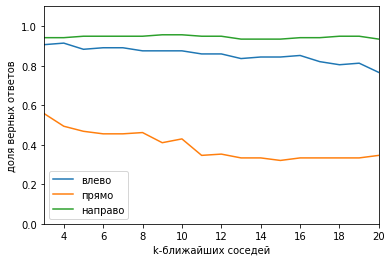

Wall time: 1min 37s


In [42]:
%%time
index = np.array([i for i, _ in enumerate(y_res)])
mask = np.random.choice([True, False], size=len(y_res), p=[0.5, 0.5])
i_tr = index[mask]
i_te = index[~mask]

X_train = X_res[i_tr]
X_test = X_res[i_te]
y_train = y_res[i_tr]
y_test = y_res[i_te]

columns = ["k", "class1", "class2", "class3"]
df = pd.DataFrame(columns=columns)

for i in tq(range(3, 21, 1)):

    clf = KNN(i)
    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)
    score = [i]

    for j in [1, 2, 3]:

        index = np.where(y_test == j)
        score.append(
            (predicted[index] == y_test[index]).sum() / len(y_test[index]))

    tempr = pd.DataFrame([score], columns=columns)
    df = df.append(tempr, ignore_index=True)

print(method)
plt.plot(df.iloc[:, 0], df.iloc[:, 1:])
plt.legend(["влево", "прямо", "направо"], loc="best")
plt.xlabel("k-ближайших соседей")
plt.ylabel("доля верных ответов")
plt.ylim(0, 1.1)
plt.xlim(df.k.min(), df.k.max())
plt.show()

In [8]:
# скользяящий контроль по 5-ти фолдам
clf = KNN(k=3)
clf.fit(X_res, y_res)
cv = clf.cv(X_res, y_res, cv=5)

print("*** Результат скользящего контроля ***")
print(method)
print("\nДоли верных ответов:", cv)
print("Среднее: %0.2f" % cv.mean())


*** Результат скользящего контроля ***
(начальный дисбаланс)

Доли верных ответов: [0.61728395 0.64197531 0.59259259 0.67901235 0.69135802]
Среднее: 0.64


## Оценка важности признаков
Перемешиваем значения признака. Вычисляем долю верных ответов (скользящи контролем), которую сравниваем с изначальным значением. Если доля верных ответов снизилась, значит признак важен для модели. Но, данная схема не работает если есть коррелируемые признаки.

In [19]:
X_res

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 0., 2.],
       ...,
       [2., 0., 2., ..., 1., 1., 1.],
       [2., 2., 0., ..., 1., 0., 0.],
       [2., 2., 2., ..., 0., 2., 0.]])

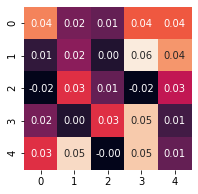

In [20]:
# оценка важности признаков (perturbation importance)
clf.feature_importance(X_res, y_res)

# Перебалансировка классов

## Метод перебалансировки Random sampling

In [21]:
def random_sampling(X_, y_, method="over-sampling"):
    class_list = list(set(y_))
    cnt = [len(y_[y_ == i]) for i in class_list]

    min_ = cnt[np.argsort(cnt)[0]]
    max_ = cnt[np.argsort(cnt)[-1]]

    for i in [0, 1, 2]:
        amount = cnt[i]
        cls = class_list[i]
        X_c = X_[y_ == cls]

        if method == "over-sampling":
            while amount < max_:
                ind = random.randrange(0, X_c.shape[0])
                X_bs = np.array([X_c[ind]])
                X_ = np.concatenate((X_, X_bs), axis=0)
                y_ = np.append(y_, cls)
                amount += 1

        if method == "under-sampling":
            while amount > min_:
                y_index = np.where(y_ == cls)[0]
                index = random.choice(y_index)
                X_ = np.delete(X_, index, axis=0)
                y_ = np.delete(y_, index)
                amount -= 1

    return X_, y_

### Under sampling 
    Перебалансировка удалением случайного наблюдения из больших классов до числа наблюдений соответствующих минимальному классу
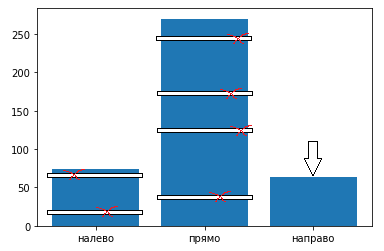


*** Перебалансировка классов до минимального ***


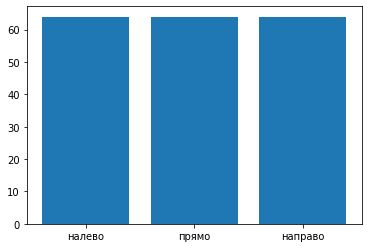

*** Результат скользящего контроля ***

Доли верных ответов: [0.39473684 0.57894737 0.55263158 0.55263158 0.42105263]
Среднее: 0.50
Wall time: 1.37 s


In [32]:
%%time
method = "under-sampling"
X_res, y_res = random_sampling(X, y, method=method)

clf = KNN(k=3)
clf.fit(X_res, y_res)
cv = clf.cv(X_res, y_res, cv=5)

print("*** Перебалансировка классов до минимального ***")
plot_classes(y_res)
print("*** Результат скользящего контроля ***")
print("\nДоли верных ответов:", cv)
print("Среднее: %0.2f" % cv.mean())

### Over sampling
    Перебалансировка добавлением случайного наблюдения малым классам до числа наблюдений соответствующих максимальному классу (своеобразный Bootstrap).
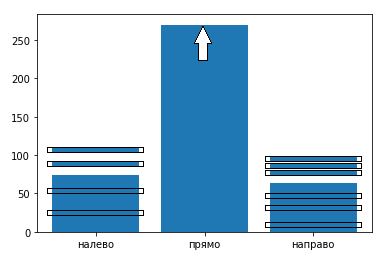


*** Перебалансировка классов до максимального ***


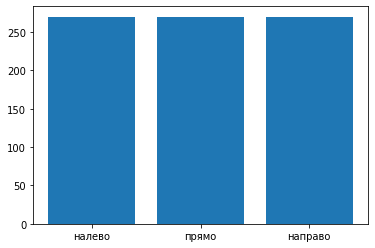

*** Результат скользящего контроля ***

Доли верных ответов: [0.89506173 0.81481481 0.86419753 0.77777778 0.83950617]
Среднее: 0.84
Wall time: 17.3 s


In [38]:
%%time
method = "over-sampling"
X_res, y_res = random_sampling(X, y, method=method)

clf = KNN(k=3)
clf.fit(X_res, y_res)

cv = clf.cv(X_res, y_res, cv=5)

print("*** Перебалансировка классов до максимального ***")
plot_classes(y_res)
print("*** Результат скользящего контроля ***")
print("\nДоли верных ответов:", cv)
print("Среднее: %0.2f" % cv.mean())

## Генерация новых наблюдений. Класс SMOTE: Synthetic Minority Over-sampling Technique
    Случайно выбирается наблюдение. Для него определяются k ближайших. Случайно выбирается одно из них. Новое наблюдение генерируется умножением случайного значения от 0 до 1 на расстояние между каждым признаком этой пары наблюдений. В дальнейшем сгенерированное наблюдение не используется при поиске k ближайших при создании новых наблюдений.
    
    Таким образом можно создавать наблюдения для малых классов балансируя выборку, а также добавлять наблюдения к наибольшему классу, увеличивая общее число наблюдений.
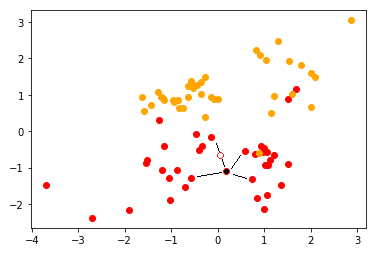

In [46]:
class SMOTE:
    def __init__(self, k=4, observations=0):
        self.k = k
        self.ob = observations

    def fit(self, X, y):
        self.X_res = X
        self.y_res = y

    def distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2)**2))

    def transform(self):
        self.classes = np.unique(self.y_res)
        # определение числа наблюдений по каждому классу
        self.counts = [np.where(self.y_res == i)[0].shape[0] for i in self.classes]

        if self.ob == 0:
            self.ob = max(self.counts)

        for ind, c in enumerate(self.classes):
            amount = self.counts[ind]
            
            if amount == self.ob:
                continue

            X_c = self.X_res[self.y_res == c]

            sample_len = self.ob - amount
            sample_ind = [random.randrange(0, amount - 1) for i in range(sample_len)]

            # продолжаем генерировать наблюдения до заданного количества
            while amount < self.ob:

                for ind in sample_ind:
                    x_parent = X_c[ind] # здесь будут исходные наблюдения
                    x_new = [] # здесь будут новые наблюдения

                    # находим k ближайших
                    distances = [self.distance(x_parent, x) for x in X_c]
                    k_nearest = np.argsort(distances)[1:self.k + 1]
                    
                    # выбираем случайное из них
                    x_random = X_c[random.choice(k_nearest)]
                    # умножаем расстояние между ними на случайное значение
                    delta = np.abs(x_parent - x_random) * random.random()

                    # полученное растояние конвертируем в признак
                    for x_p, x_r, dlt in zip(x_parent, x_random, delta):
                        x_new.append(min(x_p, x_r) + dlt)
                    
                    x_new = np.array([x_new])
                    
                    # добавляем сгенерированное наблюдение
                    self.X_res = np.concatenate((self.X_res, x_new), axis=0)
                    self.y_res = np.append(self.y_res, c)

                    amount += 1

        return self.X_res, self.y_res


SMOTE, добавлено наблюдений по каждому классу до: 1000


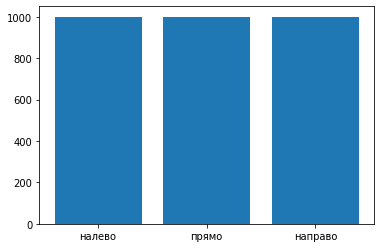

*** Результат скользящего контроля ***

Доли верных ответов: [0.94       0.96333333 0.95666667 0.94166667 0.94333333]
Среднее: 0.95
Wall time: 4min 6s


In [47]:
%%time
# добавить наблюдений до
observations = 1000
method = "SMOTE"

# по ближайшим k соседям
res = SMOTE(k=3, observations=observations)
res.fit(X, y)

X_res, y_res = res.transform()

clf = KNN(k=3)
clf.fit(X_res, y_res)

cv = clf.cv(X_res, y_res, cv=5)

print("SMOTE, добавлено наблюдений по каждому классу до:", observations)
plot_classes(y_res)
print("*** Результат скользящего контроля ***")
print("\nДоли верных ответов:", cv)
print("Среднее: %0.2f" % cv.mean())

# Установка виджетов (widgets, Nbextensions)
Установка полезных виджетов: 
    - Contents (окошко оглавления слева)
    - Variable inspector (окошко переменных справа)
    - ScrollDown (атоматическая прокрутка вывода)
    - CodeFolding (скрытие кода)

In [1]:
!pip install jupyter_contrib_nbextensions

In [ ]:
# перезагрузить jupyter

In [1]:
!jupyter contrib nbextension install --user

In [ ]:
# перезагрузить jupyter